## PyStokes

## PyStokes
is for simulation of Stokes flow in *python*


## Scope of today's talk
to desribe the *why* and *how* of PyStokes codebase

## Outline
* simulation of Stokes flow around **active colloids**
* accelerating python
* implementation: O(N^2) and O(N)
* perspectives

##  Colloids
particles of sizes between few nanometers to several microns - usually suspended in a fluid medium

## Active colloids
a new class of colloids which create flow, even when stationary, due to large surface gradients from local nonequilibrium processes (like chemical reactions) 

## Ideal active colloid
![](idealAC.png)

## What is slip?
![](ep1.png)

## What is slip?
![](ep2.png)

## What is slip?
![](ep3.png)

## Rigid body motion
linearity of Stokes flow implies that the rigid body motion of active colloids is linearly proportional to
* irreducible modes of the slip: $\mathbf V^{l(\sigma)} \sim \int \mathbf v^{\mathcal A} \underbrace{\mathbf Y^{(l)}}_{basis} dS$
* body forces $\mathbf F^P$ and torques $\mathbf T^P$

## Rigid body motion of active colloids
![](rbm.png)

## Numerical implementation
involves computing matrix multiplication: $M \cdot A$, where $M$ is matrix of size $N^2$ and $A$ is column vector of size $N$. How to code it up?
* efficient algorithm in terms of flops and memory usage - matrix free?
* a modern programming language - python?

## Python
- is a high level language
- is free and open source
- is object-oriented
- has an interactive environment
- has a big scientific community using it...
- has several modules for scientific computation

The velocity of the $i$the colloid due to body forces on all the colloids in an unbounded medium is given as

$$ \mathbf V_i = \mu \,\mathbf F_i + \sum_{i\neq j} \left(1+\frac{b^2}{3}\nabla^2\right) \mathbf G \cdot \mathbf F_j $$

where $\mu = \frac{1}{6\pi\eta b}$ and the Green's function is 
$$G_{\alpha\beta}(\boldsymbol{r})=\frac{1}{8\pi\eta}\left(\frac1r - \frac{r_{\alpha}r_{\beta}}{r^3}\right)$$

Here $r=|\boldsymbol R_i-\boldsymbol R_j|$ and $\boldsymbol R_i$ is the position of $i$th colloid.

In [2]:
import pystokes
import numpy as np
import matplotlib.pyplot as plt 

b, Np = 1, 2**9      # radius and number of particles
eta   = 1.0/6         # viscosity
uRbm  = pystokes.unbounded.Rbm(b, Np, eta)   # instantiate the unbounded class of PyStokes

F = np.ones(3*Np, dtype=np.float);         # forces on all the colloids
r = 2*np.linspace(-3*Np, 3*Np, 3*Np);       # position of all the colloids

In [2]:
def purepStokesletV(v, r, F):
        mu=1.0/(6*np.pi*eta*b); mu1=mu*b*0.75;  aa=(2*b*b)/3
    
        for i in range(Np):
            vx=0;  vy=0;   vz=0;
            for j in range(Np):
                if i != j:
                    dx  = r[i]      - r[j]
                    dy  = r[i+Np]   - r[j+Np]
                    dz  = r[i+2*Np] - r[j+2*Np] 
                    idr = 1.0/np.sqrt(dx*dx+dy*dy+dz*dz); idr2 = idr*idr
    
                    vv1 = (1 + aa*idr2)*idr 
                    vv2 = (1-3*aa*idr2)*( F[j]*dx + F[j+Np]*dy + F[j+2*Np]*dz )*idr2*idr
                    vx += vv1*F[j]      + vv2*dx 
                    vy += vv1*F[j+Np]   + vv2*dy 
                    vz += vv1*F[j+2*Np] + vv2*dz 

            v[i]      += mu*F[i]       + mu1*vx
            v[i+Np]   += mu*F[i+Np]    + mu1*vy
            v[i+2*Np] += mu*F[i+2*Np] + mu1*vz
        return

In [3]:
def numpyStokesletV(v, r0, F0):
    mu=1.0/(6*np.pi*eta*b); mu1=mu*b*0.75;  aa=(2*b*b)/3
    r = r0.reshape(Np, 3, order='F');   F = F0.reshape(Np, 3, order='F')
    
    dx = (r[:, 0] - r[:, 0, np.newaxis])
    dy = (r[:, 1] - r[:, 1, np.newaxis])
    dz = (r[:, 2] - r[:, 2, np.newaxis])
    dr = np.sqrt(dx*dx + dy*dy + dz*dz);   np.fill_diagonal(dr, 1.0)   # to avoid divide by zero.
    idr = 1/dr;                            np.fill_diagonal(idr, 0.0)  # no distance with self!
    idr2 = idr*idr;    idr3 = idr*idr2  
    
    Fdotdr = F[:, 0, np.newaxis]*dx + F[:, 1, np.newaxis]*dy + F[:, 2, np.newaxis]*dz  
    vv1  = (1 + aa*idr2)*idr;      vv2 = (1-3*aa*idr2)*Fdotdr*idr3
    vxHI = mu1*(F[:, 0, np.newaxis]*vv1 + vv2*dx)
    vyHI = mu1*(F[:, 1, np.newaxis]*vv1 + vv2*dy)
    vzHI = mu1*(F[:, 2, np.newaxis]*vv1 + vv2*dz)
    
    v[:Np]        = mu*F0[:Np]       + np.sum(vxHI, axis = 0)
    v[Np:2*Np]    = mu*F0[Np:2*Np]   + np.sum(vyHI, axis = 0)
    v[2*Np:3*Np]  = mu*F0[2*Np:3*Np] + np.sum(vzHI, axis = 0)
    return 

![](pystokesStokeslet.png) 


In [4]:
v1 = np.zeros(3*Np, dtype=np.float);
v2 = np.zeros(3*Np, dtype=np.float);
v3 = np.zeros(3*Np, dtype=np.float);

purepStokesletV(v1, r, F);      # pure python
numpyStokesletV(v2, r, F);      # vectorized numpy
uRbm.stokesletV(v3, r, F)       # cythonized class

print(np.allclose(v1, v2),  np.allclose(v1, v3))

True True


### Speed test

In [5]:
%%timeit
purepStokesletV(v1, r, F);      # pure python

1.63 s ± 60.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
numpyStokesletV(v2, r, F);      # vectorized numpy

8.97 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
uRbm.stokesletV(v3, r, F)       # cythonized class

2.25 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


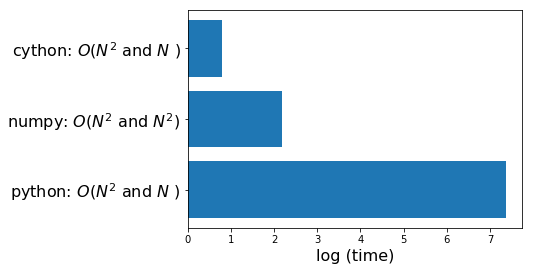

In [8]:
speed = np.log([1600, 8.9, 2.2 ]);  
tool  = ['python: $O(N^2$ and $N\,\,)$', 'numpy: $O(N^2$ and $N^2)$', 'cython: $O(N^2$ and $N\,\,)$']; 
plt.barh(np.arange(len(tool)), speed);  
plt.yticks(np.arange(len(tool)), tool, fontsize=16); 
plt.xlabel('log (time)', fontsize=16);

## Four noble truths

* slowness in python code
* cause of the slowness
* ending of the slowness 
* path to the cessation 

## Why is python slow?

* Python is interpreted
* a dynamically typed language
* GIL - global interpreter lock

## Accelerating python
* profile the code and find parts of code where most time is spent. These parts can be
    -  Vectorize - **NumPy, SciPy** which call compiled code
    - Use cython for heavy-lifting
    
* better manage the memory to the otherwise CPU hungry code!
* back of the envelope calculations - is your code flops bounds or memory bound

## Cython
Cython is an attempt to make a superset of python which has the high level coolness of python along with the speed of C. This is achieved because

* Cython is compiled
* Cython has cdef variables, attributes, functions
* Cython supports parallelism (openMP) by opening GIL.

## PyStokes design principles
* like any other python library (think numpy, Scipy etc)
* should be an independent module which can be hooked to generic environment
* Some main idea
    * does not allocate memory
    * avoid inheritance!
    * avoid division, special function calls

## Let's plot some flows

In [8]:
#Paramter declaration and memory allocations
a, eta, dim   = 1, 1.0/6, 3
L, Ng, Np, Nt = 10, 32, 1, 32*32

# memory allocation for positions (r), orientation, stresslet (S)
r, p, S = np.zeros(3*Np), np.zeros(3*Np), np.zeros(5*Np)
rt = np.zeros(dim*Nt)+L/2                   # Memory Allocation for field points
vv = np.zeros(dim*Nt)                   # Memory Allocation for field Velocities
# creating a meshgrid
xx = np.linspace(0, L, Ng)
yy = np.linspace(0, L, Ng)
X, Y = np.meshgrid(xx, yy)
rt[Nt:3*Nt] = np.concatenate((X.reshape(Ng*Ng), Y.reshape(Ng*Ng)))


#initialise the position orienation and force on the colloid
r[0], r[1], r[2]= L/2, L/2, L/2   #position
p[0], p[1], p[2]= 0, 0, 1         #orientation

#stresslet
S0=1
for i in range(Np):
    S[i]      = S0*(p[i]*p[i] -(1.0/3))
    S[i+ Np]  = S0*(p[i + Np]*p[i + Np] -(1.0/3))
    S[i+ 2*Np]  = S0*(p[i]*p[i + Np])
    S[i+ 3*Np] = S0*(p[i]*p[i + 2*Np])
    S[i+ 4*Np] = S0*(p[i + Np]*p[i + 2*Np])

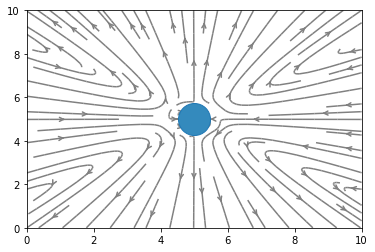

In [9]:
####Instantiate the Flow class
uFlow = pystokes.unbounded.Flow(a, Np, eta, Nt)
vv=vv*0                          

uFlow.stressletV(vv, rt, r, S) # computes flow (vv) at the location of rt in vector vv given r and F
vx, vy = vv[Nt:2*Nt].reshape(Ng, Ng), vv[2*Nt:3*Nt].reshape(Ng, Ng)

# Plot
plt.plot(r[0], r[1], marker='o', markerfacecolor='#348ABD', markersize=32 )   # plot the particle at r
plt.streamplot(X, Y, vx, vy, color="grey", density=1, arrowstyle='->', arrowsize =1)
plt.xlim([0, L]); plt.ylim([0, L]);

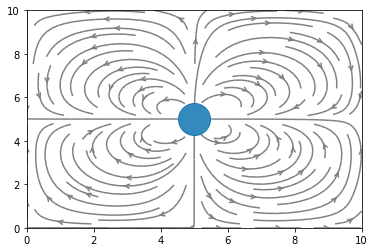

In [10]:
####Instantiate the Flow class
uFlow = pystokes.periodic.Flow(a, Np, eta, L, Nt)
vv=vv*0                          

uFlow.stressletV(vv, rt, r, S) # computes flow (vv) at the location of rt in vector vv given r and F
vx, vy = vv[Nt:2*Nt].reshape(Ng, Ng), vv[2*Nt:3*Nt].reshape(Ng, Ng)

# Plot
plt.plot(r[0], r[1], marker='o', markerfacecolor='#348ABD', markersize=32 )   # plot the particle at r
plt.streamplot(X, Y, vx, vy, color="grey", density=1, arrowstyle='->', arrowsize =1)
plt.xlim([0, L]); plt.ylim([0, L]);

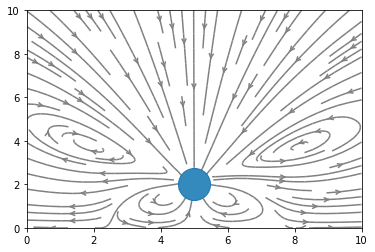

In [11]:
####Instantiate the Flow class
uFlow = pystokes.wallBounded.Flow(a, Np, eta,  Nt)
vv=vv*0; r[2]=2                         

uFlow.stressletV(vv, rt, r, S) # computes flow (vv) at the location of rt in vector vv given r and F
vx, vy = vv[Nt:2*Nt].reshape(Ng, Ng), vv[2*Nt:3*Nt].reshape(Ng, Ng)

# Plot
plt.plot(r[1], r[2], marker='o', markerfacecolor='#348ABD', markersize=32 )   # plot the particle at r
plt.streamplot(X, Y, vx, vy, color="grey", density=1, arrowstyle='->', arrowsize =1)
 
plt.xlim([0, L]); plt.ylim([0, L]);

## Demo: Simulation of apolar colloid
$$
\dot{\mathbf r}_i = \boldsymbol \pi_{ij}^{(T,2s)} \cdot\mathbf V^{(2s)}_j
$$

In [12]:
b    = 1      # radiud
N    = 1      # # particles
eta  = .1     # viscoity

In [13]:
#initialise the position orienation and force on the colloid
L=10
r[0], r[1], r[2]= L/2, L/2, L/2   #position
p[0], p[1], p[2]= 0, 0, 1         #orientation
v = np.zeros(3*N)

#stresslet
S0=2.1
for i in range(Np):
    S[i]      = S0*(p[i]*p[i] -(1.0/3))
    S[i+ Np]  = S0*(p[i + Np]*p[i + Np] -(1.0/3))
    S[i+ 2*Np]  = S0*(p[i]*p[i + Np])
    S[i+ 3*Np] = S0*(p[i]*p[i + 2*Np])
    S[i+ 4*Np] = S0*(p[i + Np]*p[i + 2*Np])
    
    
Nt, dt =10000, .01
yt, zt = np.zeros(Nt), np.zeros(Nt) 
yt[0], zt[0] = r[0], r[1]

print (S, r)

[-0.7 -0.7  0.   0.   0. ] [5. 5. 5.]


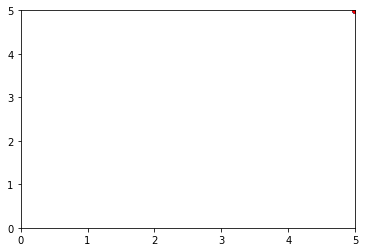

In [18]:
#instantiate the class
RBM = pystokes.unbounded.Rbm(b, N, eta)
RBM = pystokes.periodic.Rbm(b, N, L, eta)
#RBM = pystokes.wallBounded.Rbm(b, N, eta)

for i in range(Nt-1):
    v=v*0;  RBM.stressletV(v, r, S)
    yt[i+1], zt[i+1] = yt[i]+v[1]*dt, zt[i]+v[2]*dt 
    yt[i+1], zt[i+1] = yt[i]+v[1]*dt, zt[i]+v[2]*dt 
    
    r[1], r[2] = yt[i+1], zt[i+1]
    if r[2]<1:
        print('ERROR: hit the wall - breaking simulation')
        break
    
plt.plot(yt, zt, 'o');  plt.plot(yt[0], zt[0], 'ro');  plt.gca().set_xlim(left=0); plt.gca().set_ylim(bottom=0);

### Contributors
* R Adhikari
* A Bolitho
* A Laskar
* R Singh
* R Singh
* You ?